A rough copy of https://pyimagesearch.com/2021/10/25/training-a-dcgan-in-pytorch/

In [1]:
import numpy as np
from tqdm import trange
from tinygrad.tensor import Tensor
from tinygrad.nn import ConvTranspose2d, BatchNorm2d, Conv2d, Linear, optim
from tinygrad.state import get_parameters
import matplotlib.pyplot as plt
from extra.datasets import fetch_mnist
Tensor.manual_seed(1337)

In [2]:
class Generator:
    def __init__(self):
        self.ct1 = ConvTranspose2d(100, 128, 4, stride=2, bias=False)
        self.bn1 = BatchNorm2d(128)
        self.ct2 = ConvTranspose2d(128, 64, 3, stride=2, padding=1, bias=False)
        self.bn2 = BatchNorm2d(64)
        self.ct3 = ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False)
        self.bn3 = BatchNorm2d(32)
        self.ct4 = ConvTranspose2d(32, 1, 4, stride=2, padding=1, bias=False)
    
    def __call__(self, x):
        x = self.bn1(self.ct1(x).relu())
        x = self.bn2(self.ct2(x).relu())
        x = self.bn3(self.ct3(x).relu())
        x = self.ct4(x).tanh()
        return x


class Discriminator:
    def __init__(self):
        self.conv1 = Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = Conv2d(32, 64, 4, stride=2, padding=1)
        self.fc1 = Linear(3136, 512)
        self.fc2 = Linear(512, 1)
    
    def __call__(self, x):
        x = self.conv1(x).leakyrelu(0.2)
        x = self.conv2(x).leakyrelu(0.2)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).leakyrelu(0.2)
        x = self.fc2(x).sigmoid()
        return x

In [3]:
def criterion(x, y):
    return -(y * x.log() + (1 - y) * (1 - x).log()).mean()


def train_generator(discriminator, fake_data, optimizer):
    labels = Tensor.ones(fake_data.shape[0])
    output = discriminator(fake_data).reshape(-1)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.numpy().item()


def train_discriminator(discriminator, real_data, fake_data, optimizer):
    real_output = discriminator(real_data).reshape(-1)
    fake_output = discriminator(fake_data).reshape(-1)
    real_labels = Tensor.ones(fake_data.shape[0])
    fake_labels = Tensor.zeros(fake_data.shape[0])
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    optimizer.zero_grad()
    real_loss.backward()
    fake_loss.backward()
    optimizer.step()
    return (real_loss + fake_loss).numpy().item()

g_loss 3.35 d_loss 0.20: 100%|██████████| 1093/1093 [02:29<00:00,  7.33it/s]


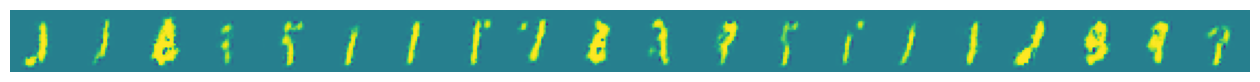

g_loss 1.88 d_loss 0.65: 100%|██████████| 1093/1093 [02:29<00:00,  7.31it/s]


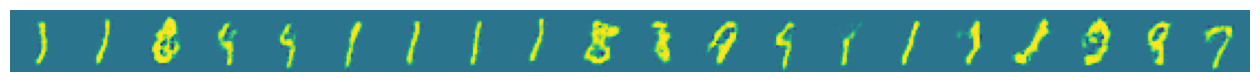

g_loss 1.52 d_loss 0.66: 100%|██████████| 1093/1093 [02:31<00:00,  7.23it/s]


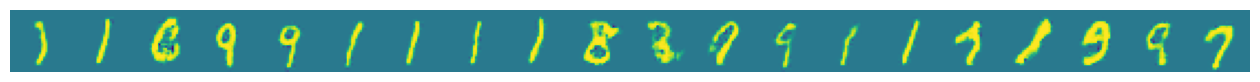

g_loss 1.62 d_loss 0.60: 100%|██████████| 1093/1093 [02:26<00:00,  7.45it/s]


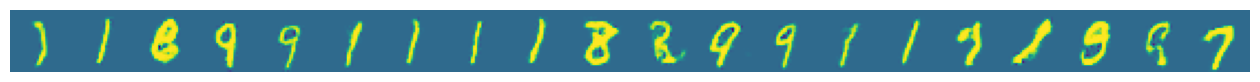

In [4]:
epochs, batch_size = 20, 64
sample_interval = epochs // 4

X = np.vstack(fetch_mnist()[::2]).reshape(-1, 1, 28, 28) / 255.0
steps = X.shape[0] // batch_size
benchmark_noise = Tensor.randn(20, 100, 1, 1, requires_grad=False)

generator, discriminator = Generator(), Discriminator()
optimizer_g = optim.AdamW(get_parameters(generator), lr=0.0001, wd=0.0001/epochs)
optimizer_d = optim.AdamW(get_parameters(discriminator), lr=0.0001, wd=0.0001/epochs)

for i in range(epochs):
    for _ in (t := trange(steps)):
        sample = np.random.randint(0, X.shape[0], size=(batch_size))
        real_images = Tensor(X[sample], requires_grad=False)
        fake_images = generator(Tensor.randn(batch_size, 100, 1, 1))
        d_loss = train_discriminator(discriminator, real_images, fake_images.detach(), optimizer_d)
        g_loss = train_generator(discriminator, fake_images, optimizer_g)
        t.set_description(f"g_loss {g_loss:.2f} d_loss {d_loss:.2f}")
    if (i + 1) % sample_interval == 0:
        plt.figure(figsize=(16, 5))
        images = generator(benchmark_noise).detach().numpy()
        plt.imshow(np.hstack(images.reshape(-1, 28, 28)))
        plt.axis("off")
        plt.show()